In [2]:
"""
Apply on MNIST Dataset

"""
%pylab inline
import os
import keras
import cv2
import time
import numpy as np
import pandas as pd
import keras.backend as K
import tensorflow as tf

import sklearn.metrics as metrics

from keras import callbacks
from keras.models import Model
from keras.optimizers import SGD
from keras.initializers import VarianceScaling
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten,Reshape, UpSampling2D, Cropping2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import mnist
import h5py

import sys


from sklearn.cluster import KMeans


os.environ["CUDA_VISIBLE_DEVICES"]="0"

Populating the interactive namespace from numpy and matplotlib


In [61]:
# get the training and test data
(train_x, train_y), (test_x, test_y) = mnist.load_data()
train_x = np.reshape(train_x, (len(train_x), 28, 28, 1))
test_x = np.reshape(test_x, (len(test_x), 28, 28, 1)) 

(28, 28, 1)
(28, 28)
(28, 28)


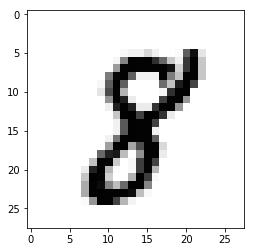

In [62]:
import matplotlib.pyplot as plt
import random
image_index = random.randint(0,100) # You may select anything up to 60,000
print(train_x[image_index].shape)

example = train_x[image_index]
width, height, channels = example.shape
example = np.squeeze(example)
print(np.squeeze(example).shape)
print(example.shape)

plt.imshow(example, cmap='Greys')

In [63]:
# Must perform normalization for the autoencoder to perform well
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255

In [9]:
keras.backend.clear_session()

In [14]:
# Combined network with both FC and CNN layers

n_samples, width, height, channels = train_x.shape
# Input
input_img = Input(shape=(width, height, 1))
# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 7, 7, 8)           584       
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 4, 8)           0         
__________

In [15]:
start_time = time.time()
train_history = autoencoder.fit(train_x, train_x, epochs=200, batch_size=2048, validation_data=(test_x, test_x))
print("Total time it took to train autoencoder is ", time.time() - start_time, " seconds")

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 83s 1ms/step - loss: 0.1570 - val_loss: 0.1142
Epoch 2/200
60000/60000 [==============================] - 80s 1ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 3/200
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/200
60000/60000 [==============================] - 89s 1ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/200
60000/60000 [==============================] - 87s 1ms/step - loss: 0.1120 - val_loss: 0.1139
Epoch 6/200
60000/60000 [==============================] - 85s 1ms/step - loss: 0.1119 - val_loss: 0.1131
Epoch 7/200
60000/60000 [==============================] - 87s 1ms/step - loss: 0.0872 - val_loss: 0.0640
Epoch 8/200
60000/60000 [==============================] - 84s 1ms/step - loss: 0.0578 - val_loss: 0.0533
Epoch 9/200
60000/60000 [=============================

In [16]:
# save the trained model
autoencoder.save('indexing_mnist_autoencoder.h5')

In [64]:
from keras.models import load_model
start_time = time.time()
autoencoder = load_model('indexing_mnist_autoencoder.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
print('Model loaded in: ', time.time() - start_time)

Model loaded in:  2.153085947036743


In [66]:
# encode database of images
codes = encoder.predict(train_x)

codes = codes.reshape(-1, 4*4*8)

# train for closest images using nearest neighbour
from sklearn.neighbors import NearestNeighbors
k = 5
knn = NearestNeighbors(n_neighbors=k).fit(codes)

print(codes.shape)

(60000, 128)


Query Images:


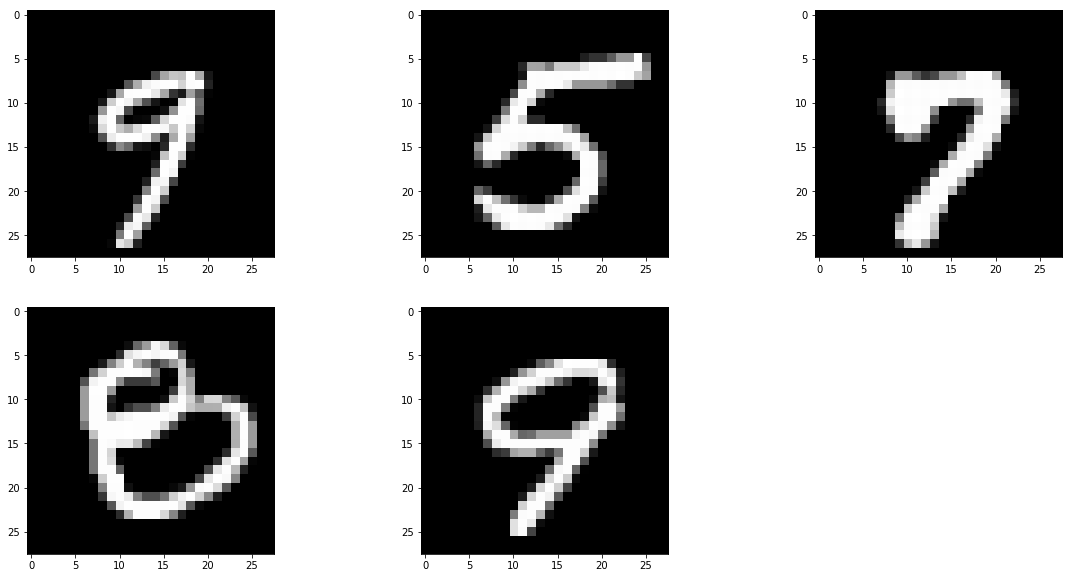

In [67]:
query_indices = np.random.randint(test_x.shape[0], size=5)
query_images = test_x[query_indices]
fig=plt.figure(figsize=(20, 10))
columns = 3
rows = 2
print("Query Images:")
for idx, image in enumerate(query_images):
    fig.add_subplot(rows, columns, idx + 1)
    plt.imshow(np.squeeze(image), cmap="gray")
plt.show()

In [68]:
query_codes = encoder.predict(query_images)
query_codes = query_codes.reshape(-1, 4*4*8)
print(query_codes.shape)

(5, 128)


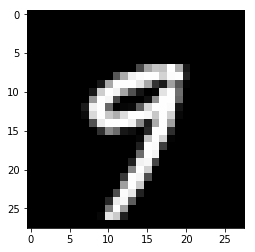

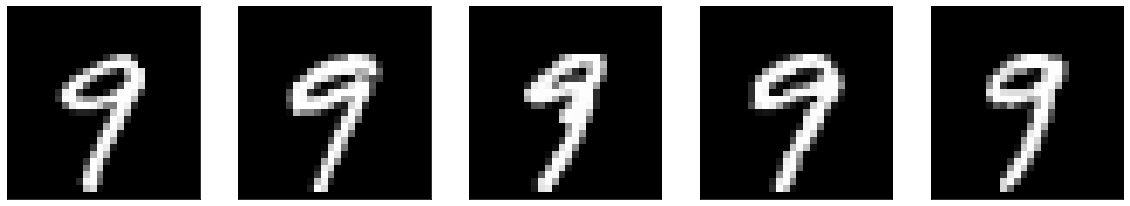

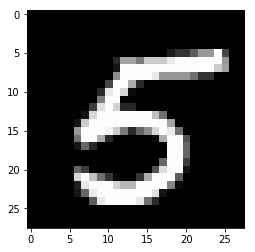

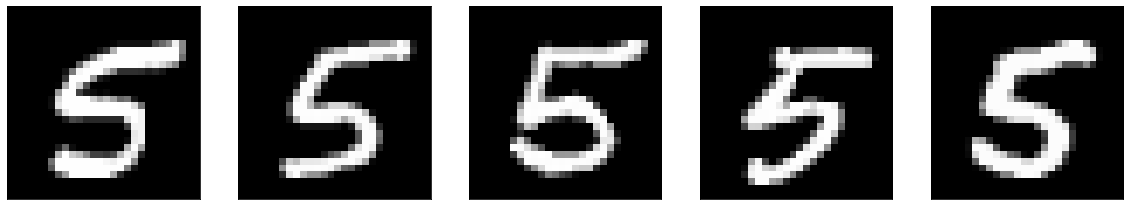

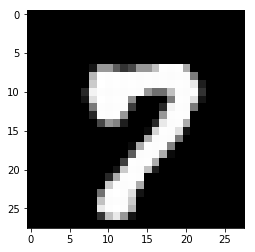

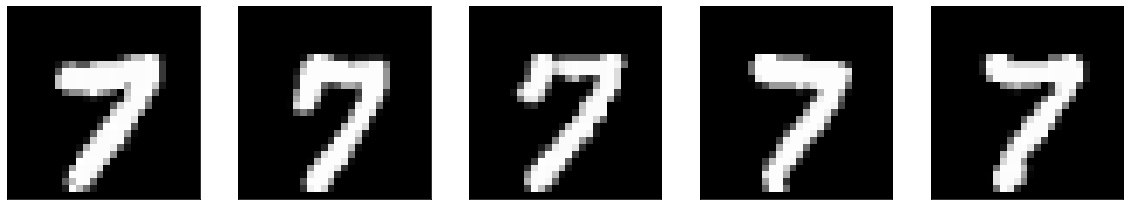

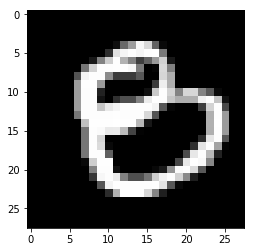

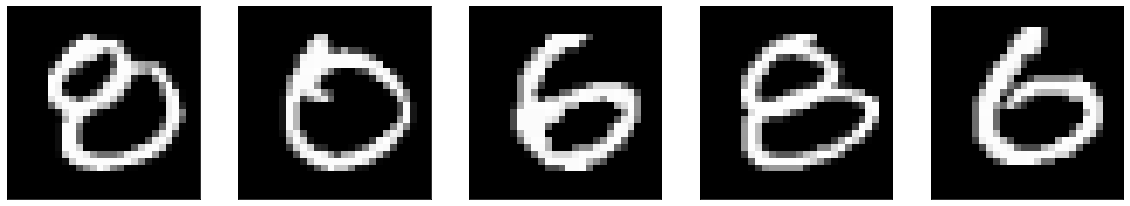

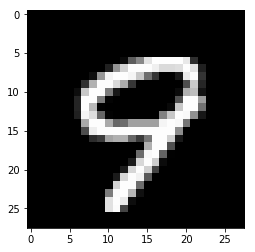

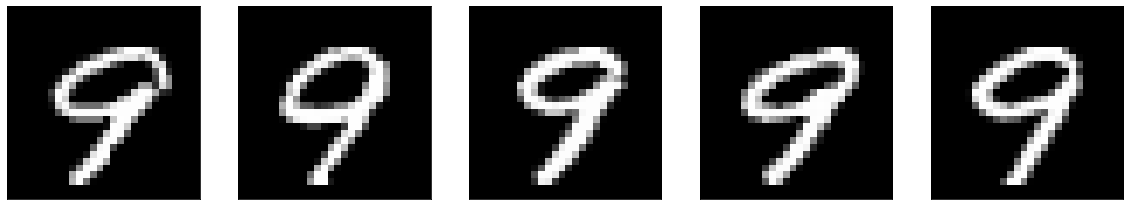

In [69]:
distances, indices = knn.kneighbors(query_codes)
for i in range(len(query_codes)):
    closest_images = train_x[indices[i]]
    plt.imshow(query_images[i].reshape(28, 28), cmap='gray')
    plt.figure(figsize=(20, 6))
    for j in range(k):
        ax = plt.subplot(1, k, j+1)
        plt.imshow(closest_images[j].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [80]:
# Get the test codes
test_codes = encoder.predict(test_x)
test_codes = test_codes.reshape(-1, 4*4*8)
print(test_codes.shape)

(10000, 128)


In [82]:
# Compute the accuracy score for the model
from sklearn.metrics import label_ranking_average_precision_score
scores = []
for num_retrieved in [100, 1000]:
    # For each num_retrieved (=number of retrieved images to assess) we store the corresponding labels and distances
    out_labels = []
    out_distances = []
    for i in range(len(test_codes)):
        distances = []
        for code in codes:
            distance = np.linalg.norm(code - test_codes[i])
            distances.append(distance)
        # Store the computed distances and corresponding labels from training dataset
        distances = np.array(distances)
        # Scoring function needs to replace similar labels by 1 and different ones by 0
        labels = np.copy(train_y).astype('float32')
        labels[labels != test_y[i]] = -1
        labels[labels == test_y[i]] = 1
        labels[labels == -1] = 0
        distance_with_labels = np.stack((distances, labels), axis=-1)
        sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]
        # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
        sorted_distances = 28 - sorted_distance_with_labels[:, 0]
        sorted_labels = sorted_distance_with_labels[:, 1]
        # We keep only num_retrieved closest elements from the images retrieved
        out_distances.append(sorted_distances[:num_retrieved])
        out_labels.append(sorted_labels[:num_retrieved])
    out_labels = np.array(out_labels)
    out_distances = np.array(out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    print("Score for top {} images retrieved: {}".format(num_retrieved, score))
    scores.append(score)


Score for top 100 images retrieved: 0.8796940804475802
Score for top 1000 images retrieved: 0.7556212370663866
